In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
import sys
sys.path.insert(0,'../code/data_utils/SampleClass/')
from Coordinates import Coordinates
sys.path.insert(1,'../code/data_utils/')
from HiCDataset import HiCDataset
from ConfigDataset import ConfigDataset
plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style_2.txt')

In [14]:
save_dir = './maps_at_different_weights/'

coord_dir = '/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/produce_samples/GM/full_scan/corrected/'
coord_dir2 = '/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/conformations/GM/'
coord_dir3 = '../data/samples/origami_64_no_embed_reduction/eval_mode/'
w1 = 1
phi1 = 0
w2 = 5
phi2 = 8
milestone=120

mcool_fp = '../data/outside/GM12878_hg19.mcool'
rosetta_fp = '../data/embeddings_64_after_transformer/rosetta_stone.pkl'
dipc_fp = '../data/processed_data.hdf5'
region_length = 1_280_000

chroms_regions = [
    ('1',1325),
    ('4',3962),
    ('10',5039),
    ('12',2396)
]

n_bootstrap_resamples = 25

In [3]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [4]:
rosetta = pd.read_pickle(rosetta_fp)
exp_hic = HiCDataset(mcool_fp)

In [5]:
config_ds = ConfigDataset(
    dipc_fp,
    segment_length=64,
    remove_diagonal=False,
    batch_size=0,
    normalize_distances=False,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=None,
    replicates=None,
    shuffle=False,
    allow_overlap=True,
    two_channels=False,
    try_GPU=False,
    mean_dist_fp=None,
    mean_sq_dist_fp=None
)

In [6]:
torch.random.manual_seed(10); # for reproducibility

In [7]:
def load_coords(chrom,region_idx,w1=float(w1),w2=float(w2),
                phi1=float(phi1),phi2=float(phi2),
                milestone=milestone,coord_dir=coord_dir,
                coord_dir2=coord_dir2):
    try:
        return (
            Coordinates(coord_dir + f'sample_{region_idx}_{w1}_{phi1}_{milestone}_{chrom}.pt'),
            Coordinates(coord_dir + f'sample_{region_idx}_{w2}_{phi2}_{milestone}_{chrom}.pt')
        )
    except:
        return (
            Coordinates(coord_dir2 + f'sample_{region_idx}_{w1}_{phi1}_{milestone}_{chrom}.pt'),
            Coordinates(coord_dir2 + f'sample_{region_idx}_{w2}_{phi2}_{milestone}_{chrom}.pt')
        )
    

In [8]:
def bootstrapped_median(
    dists1,
    dists2,
    fraction_w1,
    n=n_bootstrap_resamples
):

    # No bootstrapping necessary in these cases
    if fraction_w1 == 0:
        return dists2.median
    if fraction_w1 == .5:
        return dists1.append(dists2).median
    if fraction_w1 == 1:
        return dists1.median

    n1 = len(dists1)
    n2 = len(dists2)
    N = n1 + n2
    
    median_dist_resamples = []
    for _ in range(n):

        # Decide how many samples to draw from each 
        # set of conformations
        nn1 = ( torch.rand(N) < fraction_w1 ).sum()
        nn2 = N - nn1
    
        # Draw samples to construct new dataset, find median dists, record result
        median_dist_resamples.append(
            dists1[torch.randint(n1,(nn1,))].append(
                dists2[torch.randint(n2,(nn2,))]
            ).median
        )

    return median_dist_resamples[0].append(median_dist_resamples[1:]).median
    

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 45 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'E', 'G', 'H', 'I', 'P', 'a', 'c', 'colon', 'd', 'e', 'eight', 'f', 'five', 'four', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'q', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 38, 39, 40, 42, 43, 44, 51, 68, 70, 71, 72, 73, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 91, 92, 1894]
INFO:fontTools.subset:

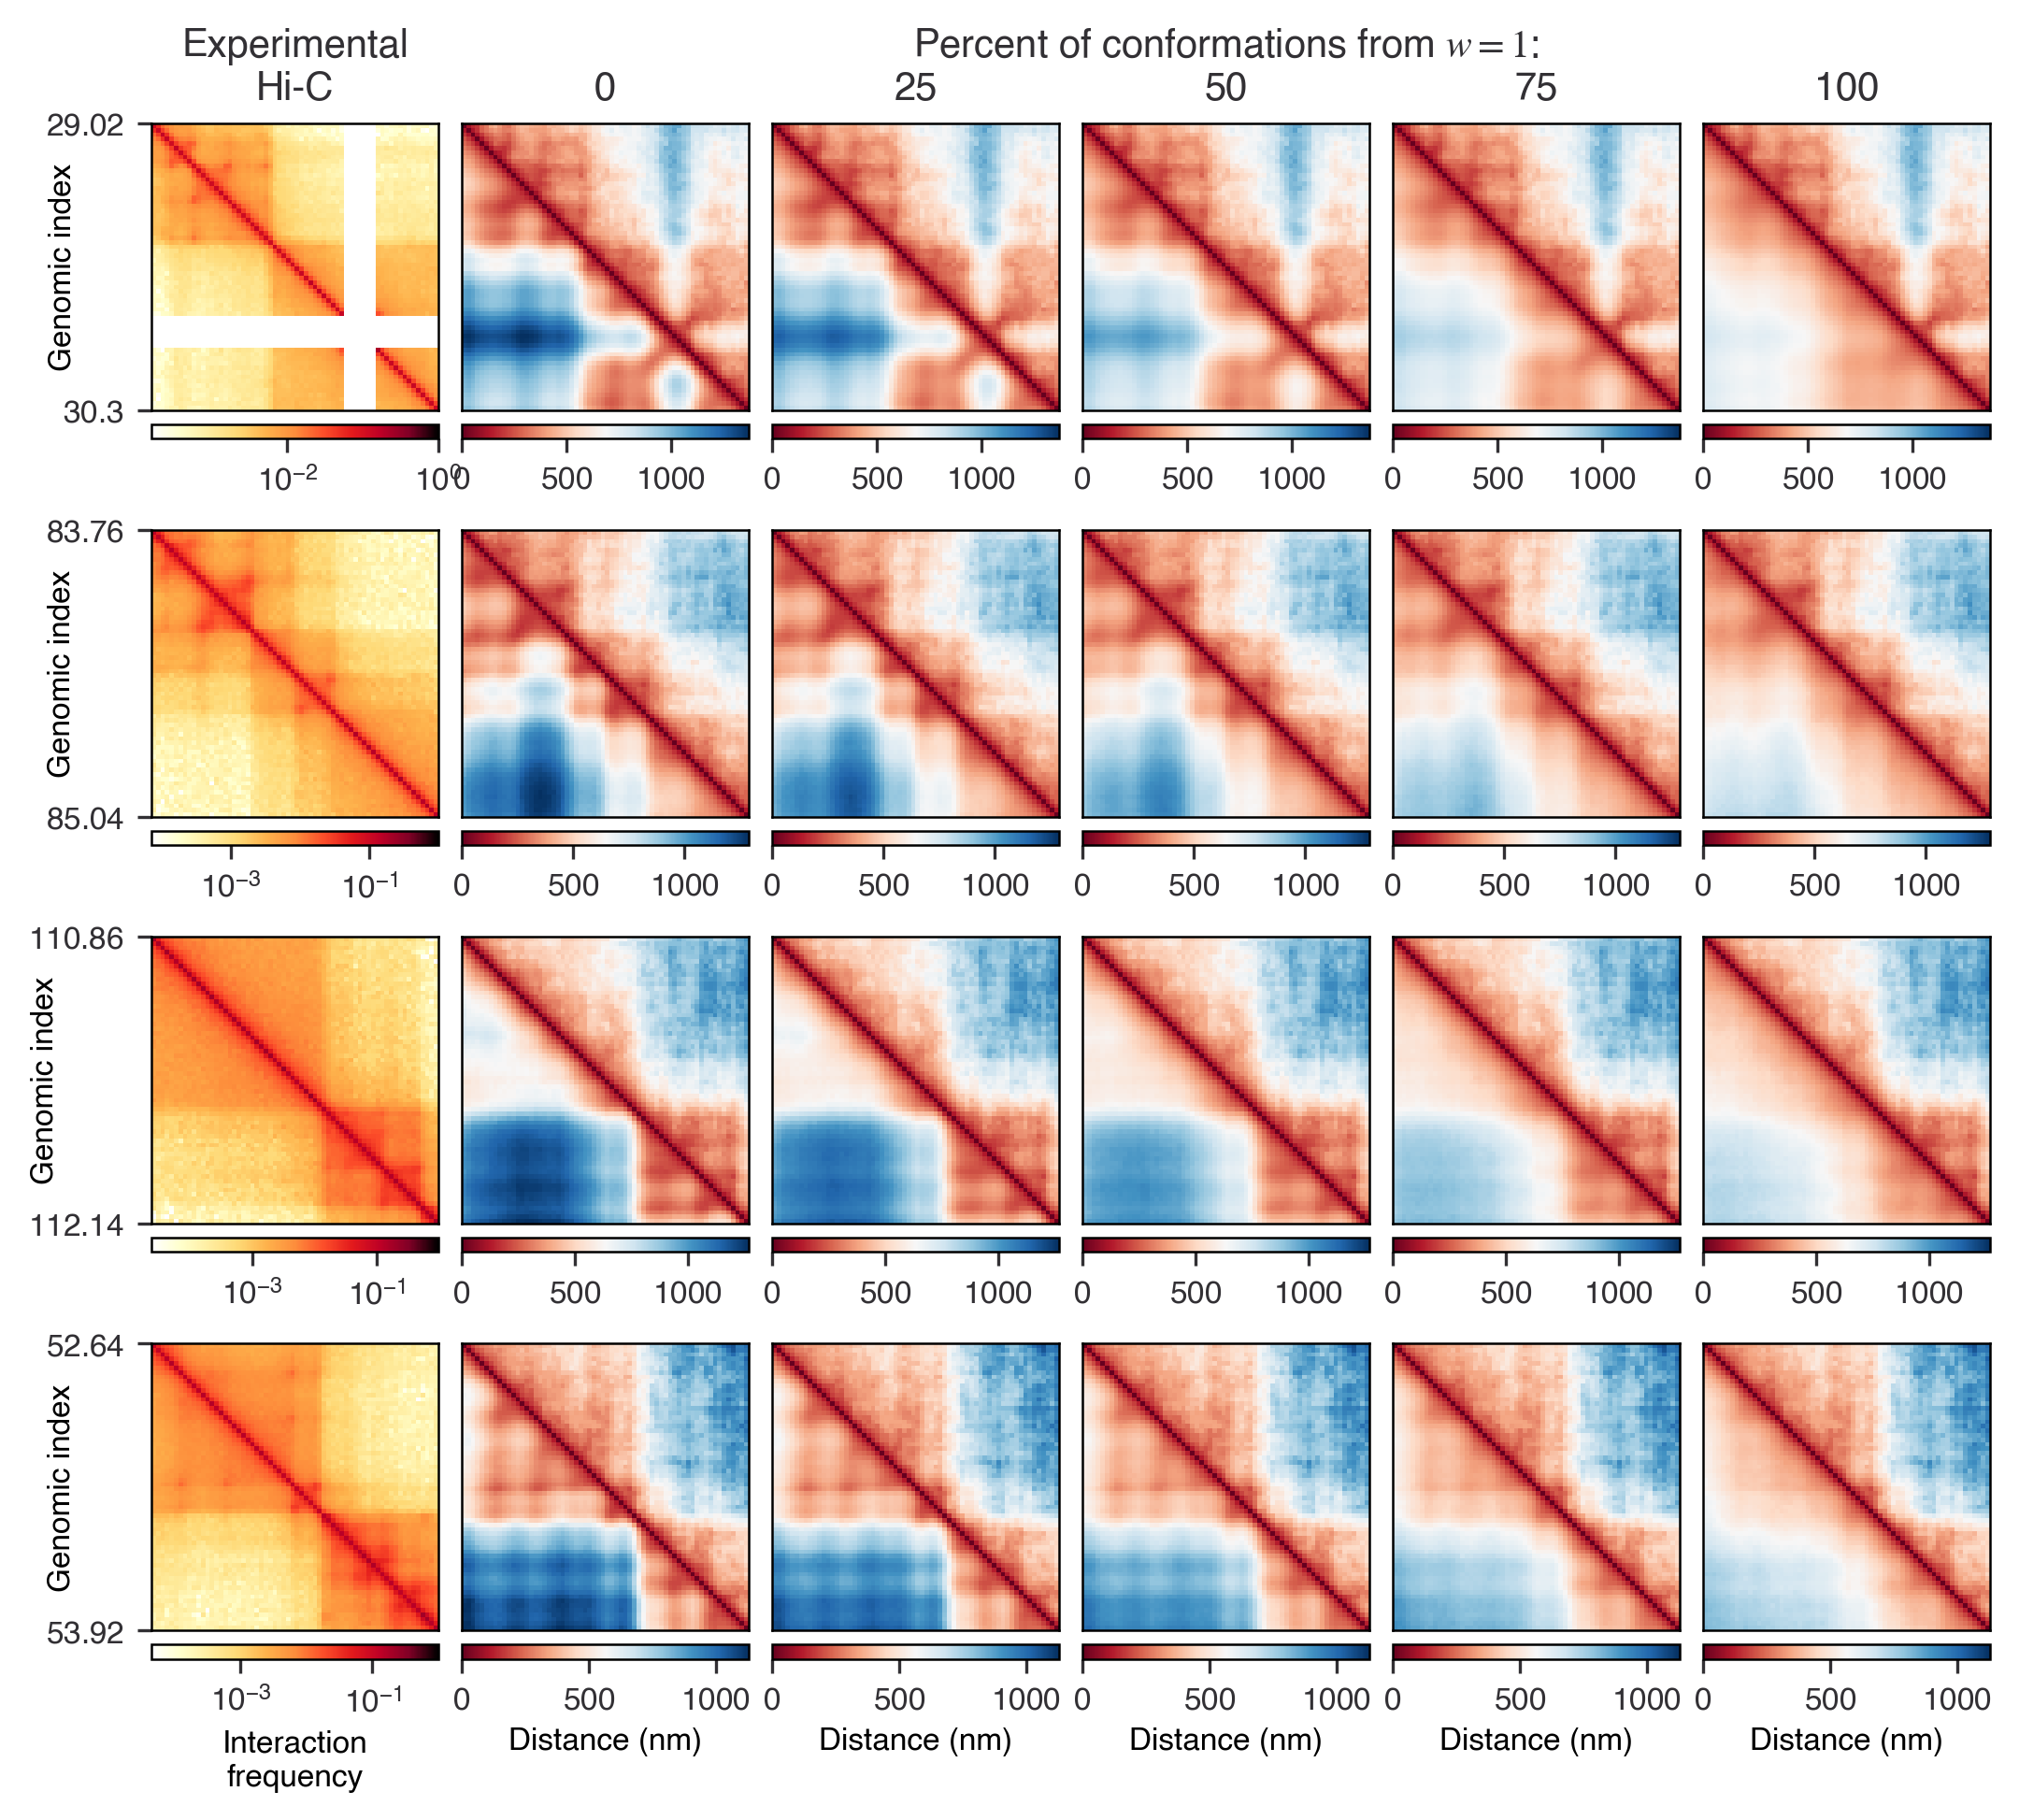

In [9]:
fig,axes = plt.subplots(nrows=4,ncols=6,figsize=(7.08,6.692*.9),layout='constrained')

w1_fractions = [0.,.25,.5,.75,1.]


for i,(chrom,region_idx) in enumerate(chroms_regions):

    coords1,coords2 = load_coords(chrom,region_idx)
    dists1 = coords1.distances
    dists2 = coords2.distances
    dists1._values*= 100 # convert to nm
    dists2._values*= 100 
    del coords1, coords2

    vmax = dists2.median.values.max()

    # Plot Hi-C
    ax = axes[i][0]
    start = rosetta[chrom][region_idx][-1]
    *_,cbar=exp_hic.fetch(chrom,start,start + region_length).plot(fig=fig,ax=ax,cbar_orientation='horizontal')
    start1 = round(start/1e6,3)
    stop1 = round((start+region_length)/1e6,3)
    ax.set_yticks(ax.get_ylim(),labels=['$\\mathdefault{'f'{v}'+'}$' for v in [stop1,start1]])
    ax.set_ylabel('Genomic index',labelpad=-8)

    if i == 0:
        ax.set_title('Experimental\nHi-C')
    if i != 3:
        cbar.set_label('')
    else:
        cbar.set_label('Interaction\nfrequency')

    # Get Dip-C coordinates
    dipc_dists = Coordinates(config_ds.fetch_specific_coords(chrom,start)[1]).distances.median.float()
    dipc_dists._values*= 100 
    
    for j,frac in enumerate(w1_fractions):

        ax = axes[i][j+1]
        
        *_,cbar = dipc_dists.plot_with(
            bootstrapped_median(dists1,dists2,frac),
            fig=fig,
            ax=ax,
            cbar_orientation='horizontal',
            vmax=vmax
        )

        if i == 0:
            if j == 2:
                ax.set_title('Percent of conformations from $w=1$:\n' + f'{round(100*frac)}')
            else:
                ax.set_title(f'{round(100*frac)}')
        if i == 3:
            cbar.set_label('Distance (nm)')
        else:
            cbar.set_label('')
        ax.set_ylabel('')
    
fig.savefig(save_dir + 'visualize_w1_fraction.pdf')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 46 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'E', 'G', 'H', 'I', 'a', 'c', 'colon', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'q', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 38, 39, 40, 42, 43, 44, 68, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 91, 92, 1894]
INFO:fontTool

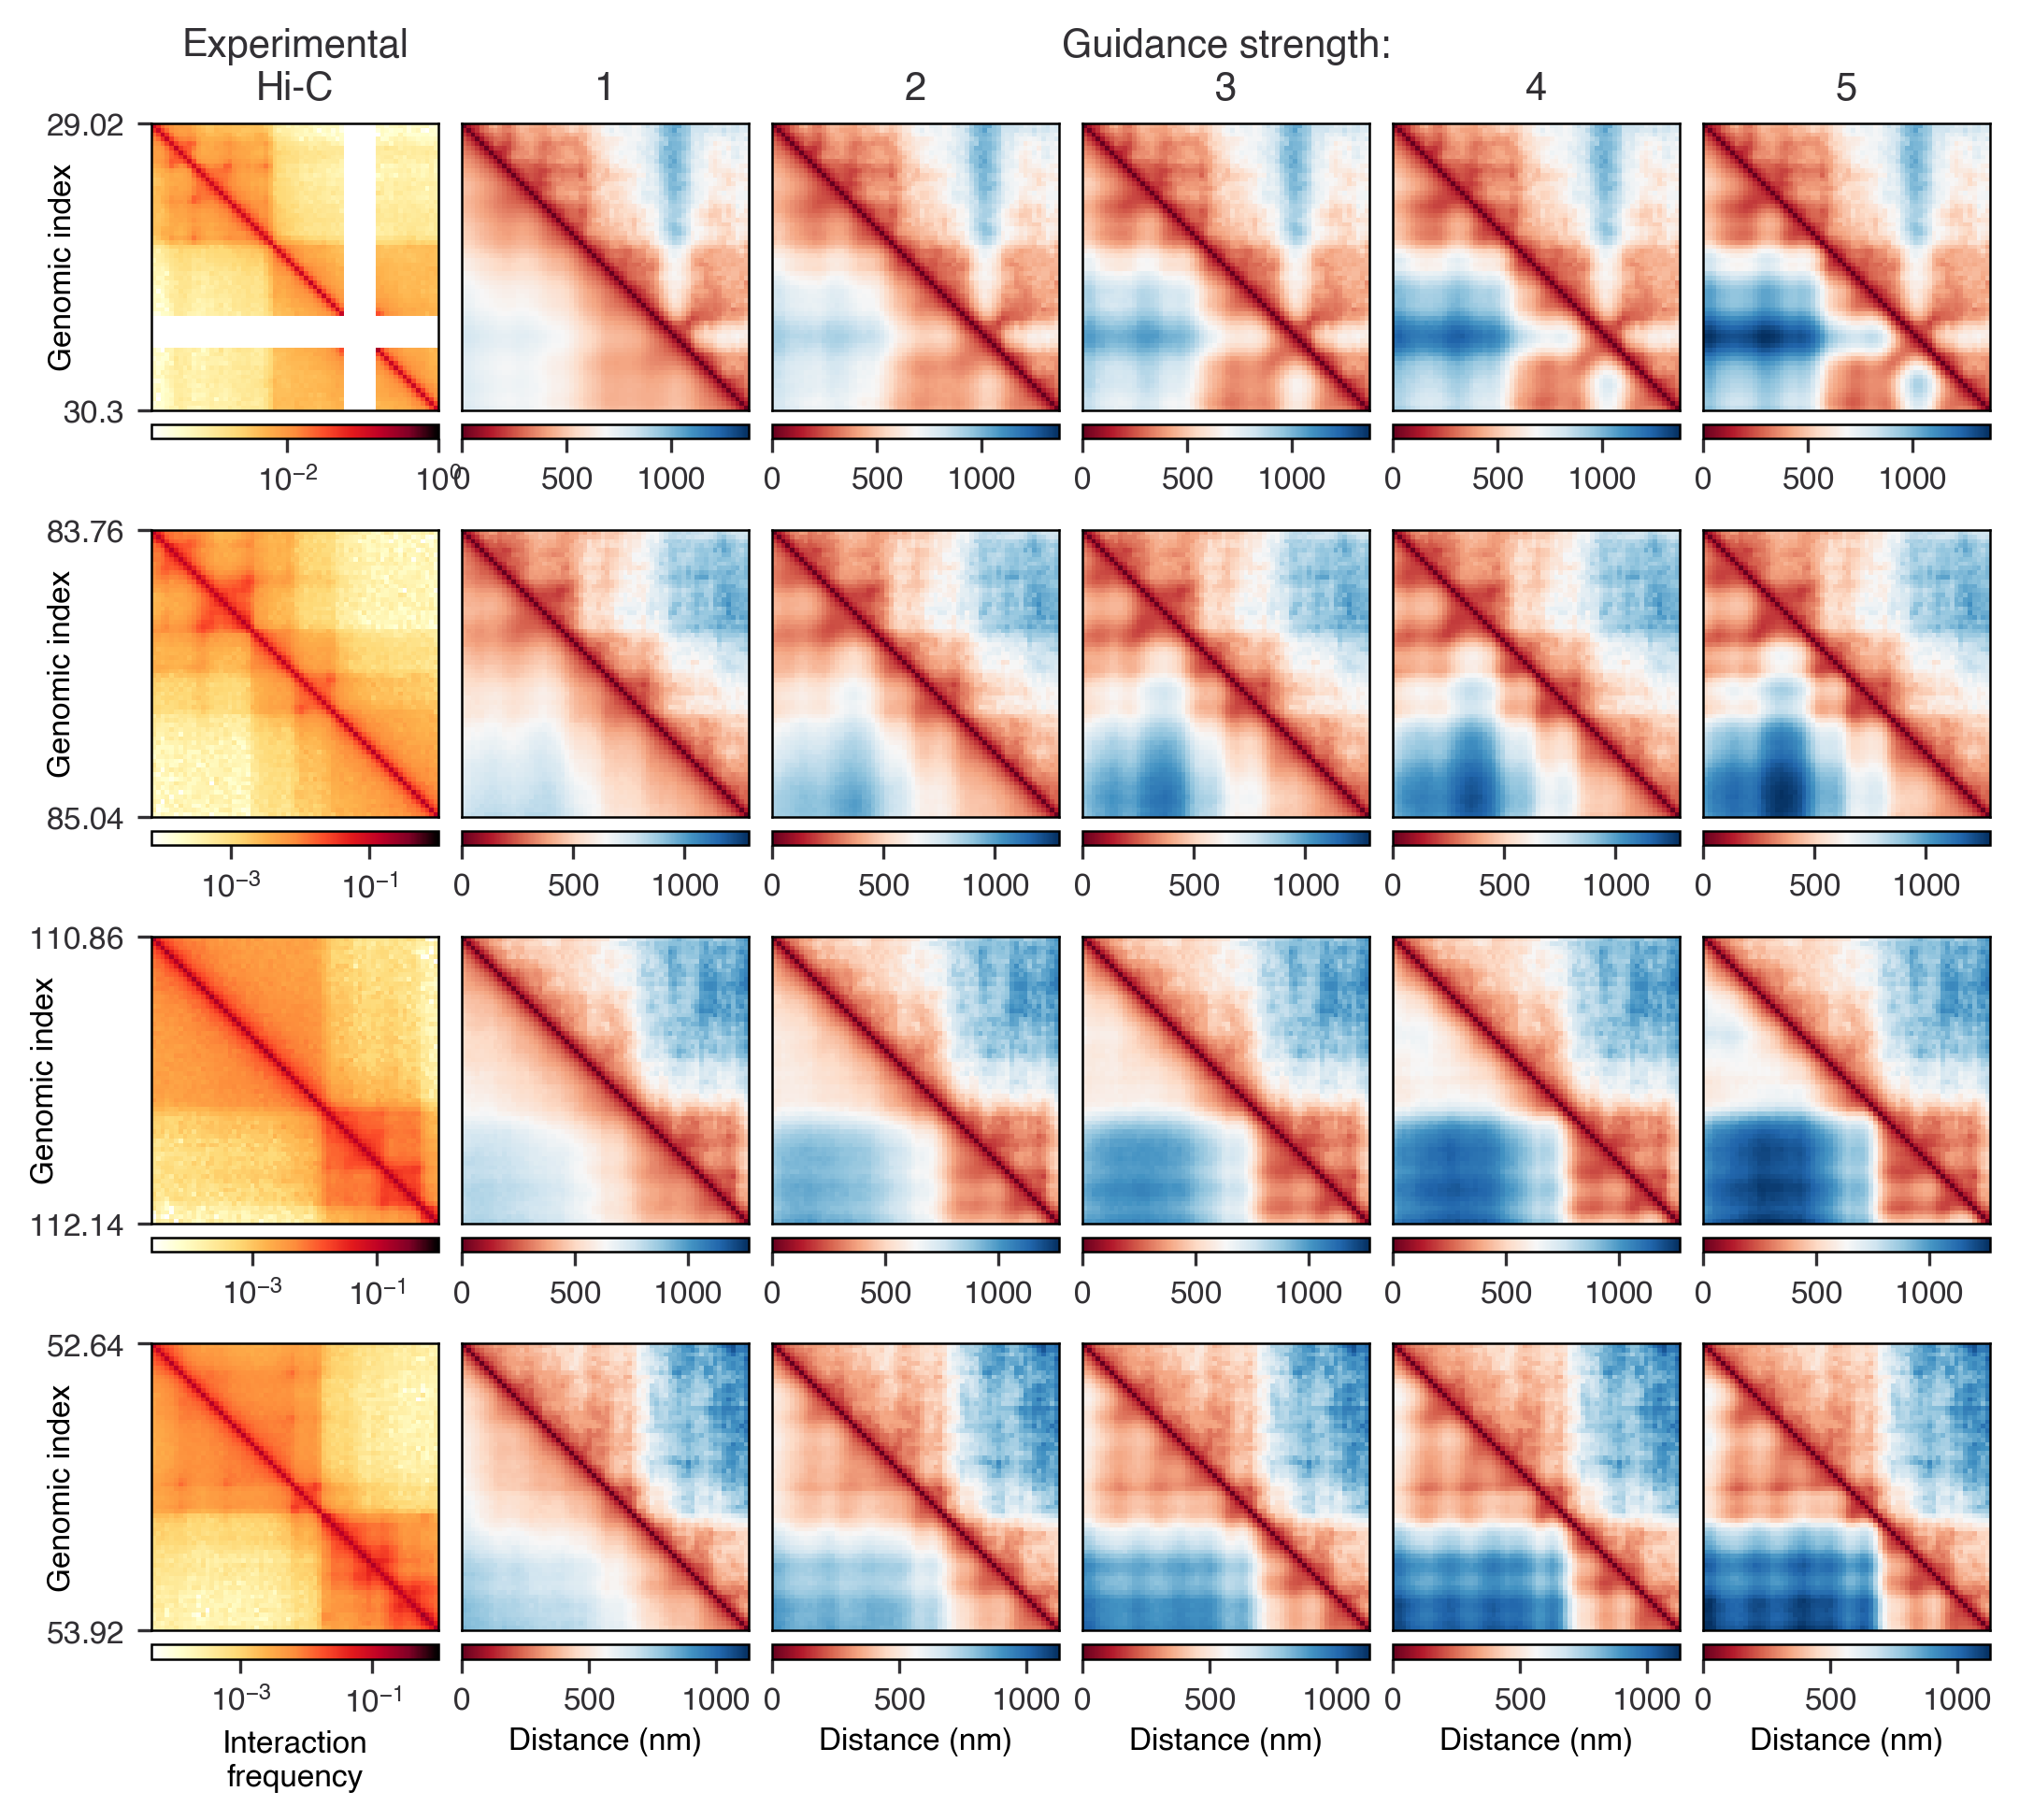

In [17]:
fig,axes = plt.subplots(nrows=4,ncols=6,figsize=(7.08,6.692*.9),layout='constrained')

guidance_strengths_phis_fractions = [
    (1.0,0.0),
    (2.0,2.0),
    (3.0,4.0),
    (4.0,6.0),
    (5.0,8.)
]


for i,(chrom,region_idx) in enumerate(chroms_regions):

    coords1,coords2 = load_coords(chrom,region_idx)
    dists1 = coords1.distances
    dists2 = coords2.distances
    dists1._values*= 100 # convert to nm
    dists2._values*= 100 
    del coords1, coords2

    vmax = dists2.median.values.max()

    # Plot Hi-C
    ax = axes[i][0]
    start = rosetta[chrom][region_idx][-1]
    *_,cbar=exp_hic.fetch(chrom,start,start + region_length).plot(fig=fig,ax=ax,cbar_orientation='horizontal')
    start1 = round(start/1e6,3)
    stop1 = round((start+region_length)/1e6,3)
    ax.set_yticks(ax.get_ylim(),labels=['$\\mathdefault{'f'{v}'+'}$' for v in [stop1,start1]])
    ax.set_ylabel('Genomic index',labelpad=-8)

    if i == 0:
        ax.set_title('Experimental\nHi-C')
    if i != 3:
        cbar.set_label('')
    else:
        cbar.set_label('Interaction\nfrequency')

    # Get Dip-C coordinates
    dipc_dists = Coordinates(config_ds.fetch_specific_coords(chrom,start)[1]).distances.median.float()
    dipc_dists._values*= 100 
    
    for j,(cond_scale,rescaled_phi) in enumerate(guidance_strengths_phis_fractions):

        f = f'sample_{region_idx}_{float(cond_scale)}_{float(rescaled_phi)}_{milestone}_{chrom}.pt'
        try:
            dists = Coordinates(coord_dir + f).distances.median
        except:
            try:
                dists = Coordinates(coord_dir2 + f).distances.median
            except:
                dists = Coordinates(coord_dir3 + f).distances.median
        dists._values*=100

        ax = axes[i][j+1]
        
        *_,cbar = dipc_dists.plot_with(
            dists,
            fig=fig,
            ax=ax,
            cbar_orientation='horizontal',
            vmax=vmax
        )

        if i == 0:
            if j == 2:
                ax.set_title('Guidance strength:\n' + f'{int(cond_scale)}')
            else:
                ax.set_title(f'{int(cond_scale)}')
        if i == 3:
            cbar.set_label('Distance (nm)')
        else:
            cbar.set_label('')
        ax.set_ylabel('')
    
fig.savefig(save_dir + 'visualize_ws.pdf')